
**Contexto:**  
As emissões de dióxido de carbono (CO₂) são o principal motor das mudanças climáticas globais. O dataset do Our World in Data fornece dados detalhados sobre emissões de CO₂, incluindo fontes (carvão, óleo, gás, cimento), intensidade econômica (CO₂ por PIB) e per capita, permitindo análises históricas e comparações entre países.

**Problema:**  
Embora os dados de emissões estejam amplamente disponíveis, a compreensão de quais países e setores contribuem mais, como as emissões evoluíram ao longo do tempo e como a intensidade econômica varia, ainda é limitada sem análises exploratórias estruturadas e visualizações claras.

**Objetivo:**  
Realizar uma análise exploratória das emissões globais de CO₂ para identificar:  
- Os países com maiores emissões absolutas e per capita.  
- A evolução histórica das emissões totais e por fonte.  
- Tendências de crescimento ou redução em diferentes regiões.  
- Relação entre emissões, PIB e população, destacando intensidade econômica.

**Principais Entregas:**  
- Ranking de países emissores absolutos e per capita.  
- Evolução histórica global e regional das emissões.  
- Análise das fontes que sustentam o crescimento ou a redução de CO₂.  
- Gráficos e mapas para apoiar interpretação e insights estratégicos.  


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set_theme(style='whitegrid')


In [99]:
# Lista todos os valores únicos de 'country' que contenham palavras-chave de agregados
keywords = ['World', 'European', 'Union', 'OECD', 'Asia', 'Africa', 'Americas', 'EU27']
aggregates_found = [c for c in df['country'].unique() if any(k in c for k in keywords)]

print("Agregados encontrados no dataset:")
for c in aggregates_found:
    print(c)

Agregados encontrados no dataset:
Africa
Africa (GCP)
Asia
Asia (GCP)
Asia (excl. China and India)
Central African Republic
European Union (27)
European Union (28)
Non-OECD (GCP)
OECD (GCP)
OECD (Jones et al.)
South Africa
World


In [100]:
import pandas as pd
from iso3166 import countries
from babel import Locale
import numpy as np

# Carrega o dataset principal
df = pd.read_csv('owid-co2-data.csv')
df = df[['country','year','iso_code','population','gdp','co2','co2_per_capita',
         'co2_growth_prct','coal_co2','oil_co2','gas_co2','cement_co2']]

# Configura locale pt
pt = Locale('pt')

# Função para converter ISO alpha3 para nome em português, mantendo agregados
def iso3_to_pt_keep_aggregates(iso3, country_name):
    # Traduz agregados específicos
    if country_name == 'World':
        return 'Mundo'
    if country_name == 'European Union (27)':
        return 'União Europeia (27)'

    # Países individuais
    if pd.isna(iso3):
        return None
    try:
        return pt.territories[countries.get(iso3).alpha2]
    except:
        # Outros agregados ou códigos não reconhecidos → mantém nome original
        return country_name

# Cria coluna country_pt com tradução
df['country_pt'] = df.apply(lambda row: iso3_to_pt_keep_aggregates(row['iso_code'], row['country']), axis=1)

# Confere o resultado
df[['country','iso_code','country_pt']].head(15)

,country,iso_code,country_pt
0,Afghanistan,AFG,Afeganistão
1,Afghanistan,AFG,Afeganistão
2,Afghanistan,AFG,Afeganistão
3,Afghanistan,AFG,Afeganistão
4,Afghanistan,AFG,Afeganistão
5,Afghanistan,AFG,Afeganistão
6,Afghanistan,AFG,Afeganistão
7,Afghanistan,AFG,Afeganistão
8,Afghanistan,AFG,Afeganistão
9,Afghanistan,AFG,Afeganistão


### Limpeza e Preparação do Dataset de CO₂

- **Remoção de dados incompletos:** excluí linhas sem informações de país ou ano.  
- **Tratamento de valores ausentes:** substituí NaNs nas emissões por fonte de energia (carvão, óleo, gás, cimento) por 0, e preenchi faltantes de população e PIB por interpolação linear.  
- **Ordenação e padronização:** organizei os dados por país e ano, e converti colunas para tipos apropriados (inteiro para ano, float para população, PIB e CO₂).  
- **Criação de métricas adicionais:**  
  - `co2_per_capita` – emissões per capita.  
  - `co2_per_gdp` – intensidade de emissões por unidade de PIB.  
  - `total_energy_co2` – somatório das emissões fósseis principais.  

Esses ajustes deixam o dataset pronto para análise exploratória  e visualizações sobre emissões globais de CO₂.

In [101]:
df = df.dropna(subset=['country', 'year']).copy()
df[['coal_co2','oil_co2','gas_co2','cement_co2']] = df[['coal_co2','oil_co2','gas_co2','cement_co2']].fillna(0)

df = df.sort_values(['country','year']).reset_index(drop=True)
for col in ['population','gdp']:
    df[col] = df.groupby('country')[col].transform(lambda s: s.interpolate(method='linear', limit_direction='both'))

df['year'] = df['year'].astype(int)
for col in ['population','gdp','co2']:
    df[col] = df[col].astype(float)

df['co2_per_gdp'] = np.where(df['gdp'] > 0, df['co2'] / df['gdp'], np.nan)
df['co2_per_capita'] = np.where(df['population'] > 0, (df['co2'] * 1_000_000) / df['population'], np.nan)
df['total_energy_co2'] = df['coal_co2'] + df['oil_co2'] + df['gas_co2'] + df['cement_co2']
df.shape


(50411, 15)

In [102]:
latest_year = int(df['year'].max())

# Filtrar último ano e apenas países com ISO code válido (Não pegar regições por engano, apenas países)
latest = df[(df['year'] == latest_year) & df['iso_code'].fillna('').str.len().eq(3)].copy()

# Selecionar top 10 emissores por CO₂, tirar linhas com emissões nulas, Descendete por emissões
top10 = latest[['country_pt','co2','co2_per_capita','year']] \
    .dropna(subset=['co2']) \
    .sort_values('co2', ascending=False) \
    .head(10)

# Formatar números com separador de milhar e duas casas decimais
top10_formatted = top10.style.format({
    'co2': '{:,.0f}',                # Bilhoes de toneladas, sem decimais
    'co2_per_capita': '{:,.2f}'     # toneladas per capita, 2 casas decimais

})

top10_formatted

,country_pt,co2,co2_per_capita,year
9933,China,"12,289",8.66,2024
48007,Estados Unidos,"4,904",14.20,2024
21762,Índia,"3,193",2.20,2024
38314,Rússia,"1,781",12.29,2024
23812,Japão,962,7.77,2024
21937,Indonésia,812,2.87,2024
22662,Irã,793,8.66,2024
40289,Arábia Saudita,692,20.38,2024
43038,Coreia do Sul,584,11.29,2024
18319,Alemanha,572,6.77,2024


## Insights

- **Último ano analisado:** 2024.
- **Evolução histórica das emissões globais:** de **9 Mt em 1750** para **38.599 Mt em 2024**, um aumento de **~430.000%**, refletindo crescimento industrial e expansão do uso de combustíveis fósseis.
- **Crescimento populacional global:** de ~0,75 bilhões em 1750 para ~8,16 bilhões em 2024 (+983%).
- **Emissões per capita:** caíram de ~12 t/pessoa em 1750 para ~4,7 t/pessoa em 2024, indicando que o aumento absoluto de emissões está parcialmente diluído pelo crescimento populacional.
- **Total de energia fóssil em 2024:** 37.758 Mt CO₂, representando a **maior parte das emissões globais**, confirmando que combustíveis fósseis ainda dominam a matriz energética.
- **Tendência:** crescimento persistente das emissões globais, com variações pontuais e desacelerações, mas a contribuição dos combustíveis fósseis continua elevada.

,Ano,População (milhões),CO₂ total (Gt),Total de energia fóssil (Gt)
0,1750,"753,279,296",9,9
1,2024,"8,161,972,574","38,599","37,758"


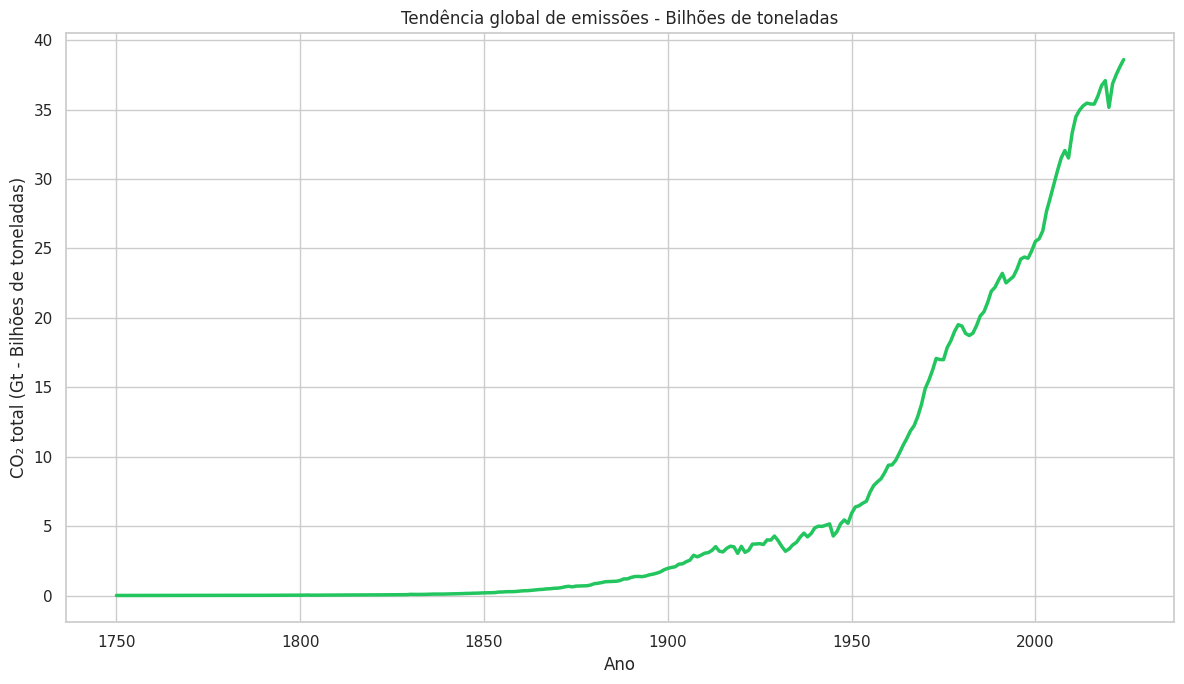

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Selecionar dados globais
world = df[df['country'] == 'World'][[
    'year', 'co2', 'population', 'coal_co2', 'oil_co2', 'gas_co2', 'cement_co2', 'total_energy_co2'
]].copy()

world = world.sort_values('year')

# Calcular CO₂ per capita
world['co2_per_capita'] = np.where(
    world['population'] > 0,
    (world['co2'] * 1_000_000) / world['population'],
    np.nan
)

# --- Criar gráfico com eixo em bilhões de toneladas (Gt) ---
fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot(world['year'], world['co2'] / 1_000, color='#22c55e', linewidth=2.5, label='CO₂ global total')
ax1.set_xlabel('Ano')
ax1.set_ylabel('CO₂ total (Gt - Bilhões de toneladas)')  # agora em bilhões de toneladas
plt.title('Tendência global de emissões - Bilhões de toneladas')
fig.tight_layout()

# --- Criar tabela de resumo ---
summary = pd.DataFrame({
    'Ano': [world['year'].iloc[0], world['year'].iloc[-1]],
    'População (milhões)': [world['population'].iloc[0], world['population'].iloc[-1]],
    'CO₂ total (Gt)': [world['co2'].iloc[0], world['co2'].iloc[-1]],
    'Total de energia fóssil (Gt)': [world['total_energy_co2'].iloc[0], world['total_energy_co2'].iloc[-1]]
})

# Formatar números com separador de milhar
summary_formatted = summary.style.format({
    'População (milhões)': '{:,.0f}',
    'CO₂ total (Gt)': '{:,.0f}',
    'Total de energia fóssil (Gt)': '{:,.0f}'
})

summary_formatted

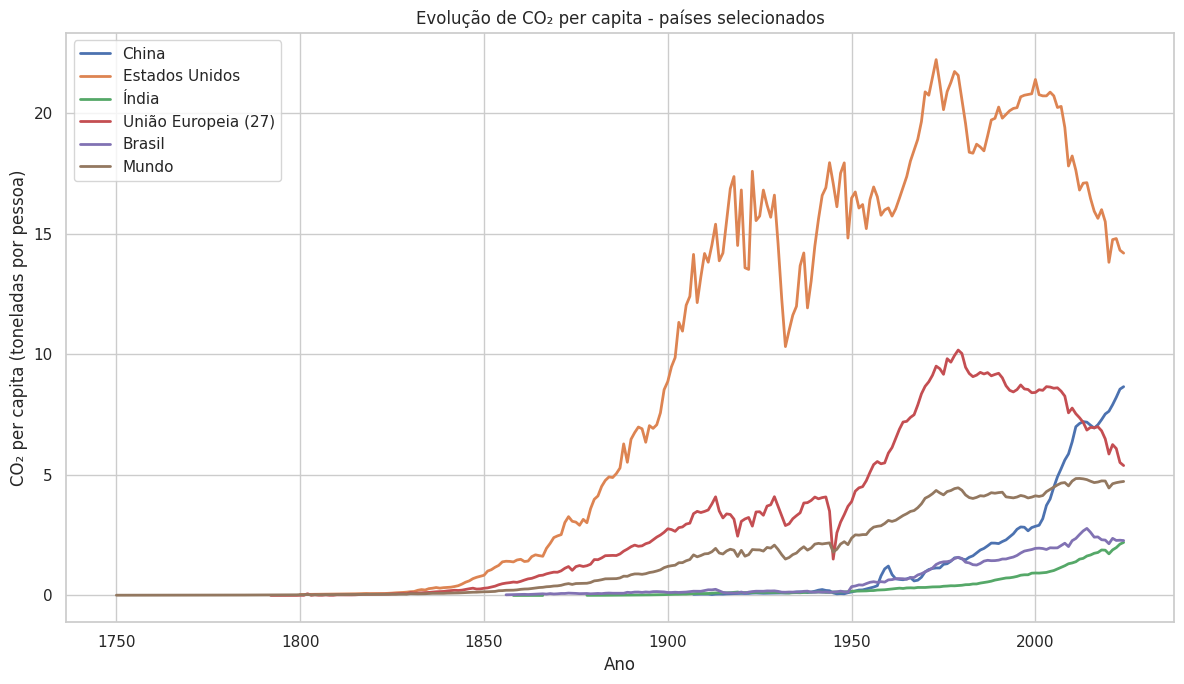

In [104]:
# Lista de países e agregados que você quer plotar (capitalização correta)
selected = ['China', 'Estados Unidos', 'Índia', 'União Europeia (27)', 'Brasil', "Mundo"]

# Mantém apenas os que estão no dataset
selected = [c for c in selected if c in df['country_pt'].unique()]

# Filtra o dataframe usando a coluna traduzida
plot_df = df[df['country_pt'].isin(selected)].copy()

# Cria gráfico
fig, ax = plt.subplots(figsize=(12,7))
for c in selected:
    s = plot_df[plot_df['country_pt'] == c]  # usa country_pt
    ax.plot(s['year'], s['co2_per_capita'], linewidth=2, label=c)

ax.set_title('Evolução de CO₂ per capita - países selecionados')
ax.set_xlabel('Ano')
ax.set_ylabel('CO₂ per capita (toneladas por pessoa)')
ax.legend(loc='upper left')
fig.tight_layout()
plt.show()

In [113]:
# Criar tabela auxiliar para CO2 per capita com população
percapita_table = latest[['iso_code','country','population','co2','co2_per_capita']].copy()


# Ordenar pelos maiores valores per capita
percapita_table = percapita_table.sort_values('co2_per_capita', ascending=False).head(20)

# Adicionar colunas legíveis
percapita_table['População (milhões)'] = percapita_table['population'] / 1_000_000
percapita_table['CO₂ total (Mt)'] = percapita_table['co2']
percapita_table['CO₂ per capita (t/pessoa)'] = percapita_table['co2_per_capita']

# Selecionar colunas finais e renomear
percapita_table_final = percapita_table[['country','População (milhões)','CO₂ total (Mt)','CO₂ per capita (t/pessoa)']]
percapita_table_final = percapita_table_final.rename(columns={'country':'País'})

# Formatar números para visualização
percapita_table_final.style.format({
    'População (milhões)': '{:,.2f}',
    'CO₂ total (Mt)': '{:,.0f}',
    'CO₂ per capita (t/pessoa)': '{:,.2f}'
})

,País,População (milhões),CO₂ total (Mt),CO₂ per capita (t/pessoa)
37960,Qatar,3.05,126,41.27
24865,Kuwait,4.93,130,26.25
7662,Brunei,0.46,12,26.05
4514,Bahrain,1.61,39,24.27
45799,Trinidad and Tobago,1.51,35,22.93
40289,Saudi Arabia,33.96,692,20.38
47507,United Arab Emirates,11.03,222,20.13
32410,New Caledonia,0.29,5,18.06
41538,Sint Maarten (Dutch part),0.04,1,16.55
35885,Oman,5.28,83,15.65


## Insights sobre CO₂ per capita – Top 15 países (2024)

- **Maiores emissores per capita:**  
  - **Qatar** lidera com 41,27 t/pessoa, seguido por **Kuwait** (26,25 t/pessoa) e **Brunei** (26,05 t/pessoa).  
  - Esses países são relativamente pequenos em população, mas altamente dependentes de combustíveis fósseis e indústria de energia.

- **Países com alta população e per capita relevante:**  
  - **Arábia Saudita** (20,38 t/pessoa), **Emirados Árabes** (20,13 t/pessoa) e **Estados Unidos** (14,20 t/pessoa) mostram que mesmo com população maior, a intensidade per capita é significativa.

- **Diferença entre per capita e total:**  
  - Alguns países com alto CO₂ per capita têm emissões totais pequenas (ex.: Brunei, Bahrain, Faroe Islands).  
  - Outros, como Estados Unidos e Arábia Saudita, combinam alto CO₂ total com intensidade elevada, impactando fortemente o clima global.

- **Insight estratégico:**  
  - CO₂ per capita ajuda a identificar países menos eficientes por pessoa.  
  - Países pequenos e ricos em energia fóssil podem parecer menos relevantes em emissões totais, mas têm altíssima intensidade individual.  
  - A combinação de CO₂ total e per capita é crucial para priorizar políticas climáticas e eficiência energética.

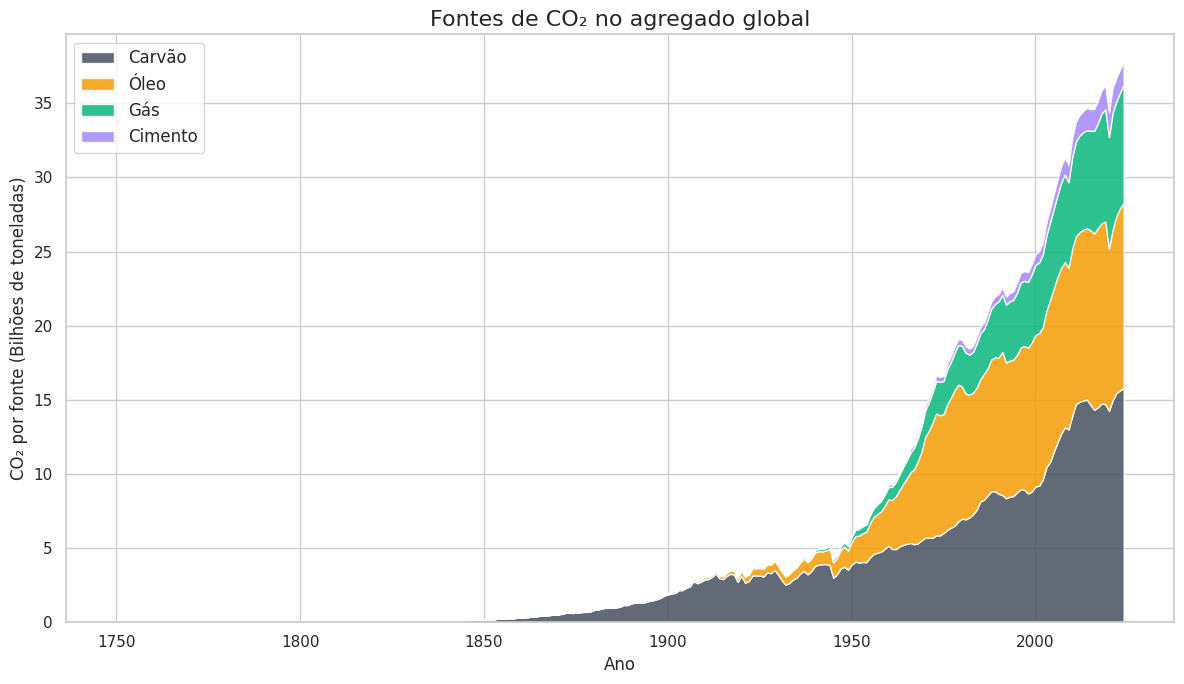

In [106]:
src = world[['year','coal_co2','oil_co2','gas_co2','cement_co2']].copy()

# Dividir por 1.000 para transformar Mt → Gt
src[['coal_co2','oil_co2','gas_co2','cement_co2']] /= 1_000

fig, ax = plt.subplots(figsize=(12,7))
ax.stackplot(
    src['year'],
    src['coal_co2'], src['oil_co2'], src['gas_co2'], src['cement_co2'],
    labels=['Carvão','Óleo','Gás','Cimento'],
    colors=['#4b5563','#f59e0b','#10b981','#a78bfa'],
    alpha=0.88
)
ax.set_title('Fontes de CO₂ no agregado global', fontsize=16)
ax.set_xlabel('Ano', fontsize=12)
ax.set_ylabel('CO₂ por fonte (Bilhões de toneladas)', fontsize=12)  # Agora correto
ax.legend(loc='upper left', fontsize=12)
fig.tight_layout()

## Distribuição de CO₂ por tipo de combustível fóssil

### Fontes de emissões de CO₂
As emissões de dióxido de carbono associadas à produção de energia e indústria podem vir de diversos tipos de combustíveis. A contribuição de cada fonte mudou significativamente ao longo do tempo e ainda apresenta grandes diferenças entre regiões.

No gráfico, é possível visualizar a contribuição absoluta e relativa das emissões de CO₂ por fonte, diferenciando carvão, óleo, gás, flaring (queima de gás) e produção de cimento.

---

### Tendências históricas globais
- A industrialização inicial foi dominada pelo uso de combustíveis sólidos, principalmente carvão.  
- A geração de energia industrial a partir de carvão surgiu primeiro na Europa e América do Norte durante os anos 1700.  
- Apenas no final dos anos 1800 começou o crescimento das emissões associadas a óleo e gás.  
- Um século depois, surgiram emissões significativas de flaring e produção de cimento.  

Hoje, combustíveis sólidos e líquidos dominam as emissões globais, embora a contribuição do gás seja relevante. Cimento e flaring permanecem relativamente pequenos em nível global.

---


**Resumo:** a evolução das fontes de CO₂ mostra a transição do uso exclusivo de carvão no início da industrialização para uma matriz energética mais diversificada atualmente, embora combustíveis fósseis sólidos e líquidos continuem dominando as emissões globais.

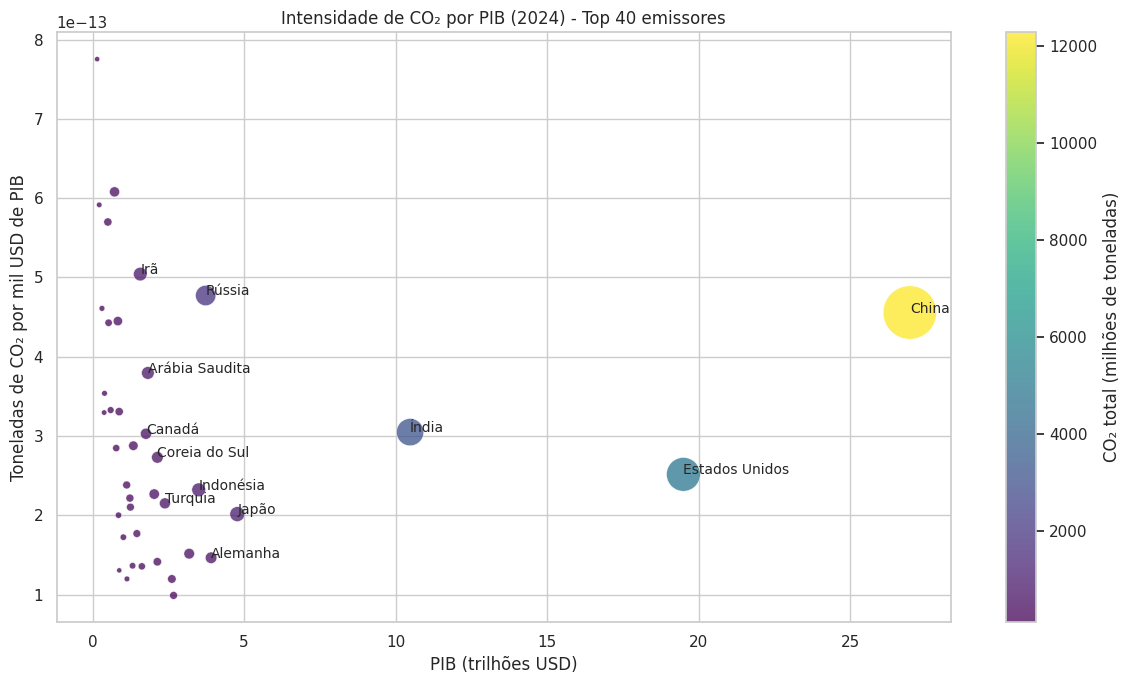

In [107]:
latest = df[(df['year'] == latest_year) & df['iso_code'].fillna('').str.len().eq(3)].copy()

# Seleciona apenas colunas importantes e limpa infinitos/nan
intensity = latest[['country_pt','co2','gdp','co2_per_gdp']].replace([np.inf, -np.inf], np.nan).dropna()
intensity = intensity[intensity['gdp'] > 0]

# Ajuste: CO2 por mil USD (em vez de por milhão)
intensity['co2_per_gdp_thousand_usd'] = intensity['co2_per_gdp'] / 1_000

# Top 40 emissores por CO2 total
plot_df = intensity.sort_values('co2', ascending=False).head(40)

fig, ax = plt.subplots(figsize=(12,7))
sc = ax.scatter(
    plot_df['gdp'] / 1_000_000_000_000,               # PIB em trilhões
    plot_df['co2_per_gdp_thousand_usd'],             # CO2 por mil USD
    s=np.clip(plot_df['co2'], 20, None) * 0.12,     # tamanho bolha
    c=plot_df['co2'], cmap='viridis', alpha=0.75,
    edgecolor='white', linewidth=0.4
)

# Anota os top 12 emissores
for _, r in plot_df.head(12).iterrows():
    ax.annotate(
        r['country_pt'],
        (r['gdp'] / 1_000_000_000_000, r['co2_per_gdp_thousand_usd']),
        fontsize=10
    )

ax.set_title(f'Intensidade de CO₂ por PIB ({latest_year}) - Top 40 emissores')
ax.set_xlabel('PIB (trilhões USD)')
ax.set_ylabel('Toneladas de CO₂ por mil USD de PIB')  # eixo Y ajustado
fig.colorbar(sc, ax=ax, label='CO₂ total (milhões de toneladas)')
fig.tight_layout()
plt.show()

In [108]:
# --- Filtrar último ano e países com ISO code válido ---
latest = df[(df['year'] == latest_year) & df['iso_code'].fillna('').str.len().eq(3)].copy()

# --- Criar coluna de intensidade de CO2 por PIB ---
latest['co2_per_gdp'] = np.where(latest['gdp'] > 0, latest['co2'] / latest['gdp'], np.nan)

# --- Preparar dados dos maiores emissores ---
intensity = latest[['country','co2','gdp','co2_per_gdp']].replace([np.inf, -np.inf], np.nan).dropna()
intensity = intensity[intensity['gdp'] > 0]

# --- Criar coluna em toneladas por milhão USD e ajustar escala para t/US$ mil ---
intensity['co2_per_gdp_million_usd'] = intensity['co2_per_gdp'] * 1_000_000
intensity['co2_per_gdp_mil_usd'] = intensity['co2_per_gdp_million_usd'] * 1_000  # escala mais legível

# --- Selecionar top 20 emissores ---
table_aux = intensity.sort_values('co2', ascending=False).head(20).copy()

# --- Formatar colunas para a tabela ---
table_aux['gdp_trilhoes'] = table_aux['gdp'] / 1_000_000_000_000
table_aux['co2_Mt'] = table_aux['co2']

# --- Selecionar e renomear colunas finais ---
table_final = table_aux[['country','gdp_trilhoes','co2_Mt','co2_per_gdp_mil_usd']]
table_final = table_final.rename(columns={
    'country':'País',
    'gdp_trilhoes':'PIB (US$ trilhões)',
    'co2_Mt':'CO₂ total (Mt)',
    'co2_per_gdp_mil_usd':'CO₂ / PIB (t/US$ mil)'
})

# --- Mostrar tabela formatada ---
table_final.style.format({
    'PIB (US$ trilhões)': '{:,.2f}',
    'CO₂ total (Mt)': '{:,.0f}',
    'CO₂ / PIB (t/US$ mil)': '{:,.2f}'
})

,País,PIB (US$ trilhões),CO₂ total (Mt),CO₂ / PIB (t/US$ mil)
9933,China,26.97,"12,289",0.46
48007,United States,19.49,"4,904",0.25
21762,India,10.48,"3,193",0.30
38314,Russia,3.73,"1,781",0.48
23812,Japan,4.77,962,0.20
21937,Indonesia,3.50,812,0.23
22662,Iran,1.57,793,0.50
40289,Saudi Arabia,1.82,692,0.38
43038,South Korea,2.14,584,0.27
18319,Germany,3.91,572,0.15


# Insights sobre emissões de CO₂

## Maiores emissores absolutos
- **China:** 12.289 Mt  
- **Estados Unidos:** 4.904 Mt  
- **Índia:** 3.193 Mt  

> Esses países dominam as emissões globais, tendo o maior impacto climático direto. Reduzir o aquecimento global depende fortemente de ações nestes países.

## Eficiência econômica (CO₂ por PIB)
- Medida em toneladas de CO₂ por mil USD de PIB, indicando quantas toneladas de CO₂ são emitidas para gerar 1.000 dólares de valor econômico.
- **Baixa intensidade:**  
  - Reino Unido (0.12), Alemanha (0.15), Japão (0.20)  
  - Produzem mais valor econômico por tonelada de CO₂, mostrando eficiência energética.
- **Alta intensidade:**  
  - África do Sul (0.61), Irã (0.50), China (0.46)  
  - Indica dependência de energia fóssil ou indústrias pesadas.

## Contexto importante
- **Alta emissão absoluta não implica baixa eficiência econômica.** Um país pode emitir muito CO₂, mas ainda usar energia de forma relativamente eficiente.  
- **Alta intensidade por PIB não significa maior impacto absoluto.** Pequenas economias podem ter alta intensidade, mas emissões totais baixas.  
- Avaliar políticas climáticas exige considerar emissões totais + intensidade por PIB simultaneamente.

## Insight estratégico
- **Grandes emissores:** Priorizar redução absoluta de CO₂ para limitar o aquecimento global.  
- **Países com alta intensidade:** Focar em transição energética, modernização industrial e eficiência, mesmo que as emissões totais não sejam as maiores.  
- O equilíbrio entre impacto absoluto e eficiência econômica é essencial para políticas climáticas eficazes.

In [109]:
map_df = latest[['iso_code','country','co2_per_capita','co2']].copy()
map_df = map_df[~map_df['iso_code'].str.startswith('OWID_')]
map_df = map_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['co2_per_capita'])

fig_map = px.choropleth(
    map_df,
    locations='iso_code',
    color='co2_per_capita',
    hover_name='country',
    hover_data={'co2':':.2f','co2_per_capita':':.2f'},
    color_continuous_scale='YlOrRd',
    title=f'CO2 per capita por pais ({latest_year})'
)
fig_map.show()


## Conclusão – Análise Global de CO₂ (2024)

A análise dos dados globais de CO₂ revela padrões importantes que ajudam a entender **impacto absoluto e eficiência econômica**:

### 1. Emissões totais
- **China, Estados Unidos e Índia** são os maiores emissores globais, representando mais de 50% do CO₂ entre os 20 maiores países.  
- Esses países concentram a maior parte do impacto climático absoluto devido à **população grande e industrialização intensa**.

### 2. Intensidade econômica (CO₂ / PIB)
- Países desenvolvidos como **Reino Unido, Alemanha e Japão** apresentam baixa intensidade, emitindo menos CO₂ por unidade econômica.  
- Países emergentes ou com indústria pesada, como **África do Sul, Irã e China**, têm maior intensidade, refletindo **dependência de combustíveis fósseis e menor eficiência industrial**.  
- Essa métrica mostra **eficiência econômica**, mas não o impacto absoluto no clima.

### 3. Intensidade individual (CO₂ per capita)
- Países pequenos e ricos em energia fóssil, como **Qatar, Kuwait e Brunei**, lideram o ranking per capita com mais de 25 t/pessoa.  
- Países com grande população, como **China, Índia e Brasil**, têm emissões per capita menores, mesmo sendo grandes emissores absolutos.  
- Essa comparação evidencia que **países com pequenas populações podem ter alta intensidade por pessoa**, mas impacto total limitado, enquanto grandes emissores dominam o efeito climático global.

### 4. Insight estratégico
- Para **reduzir aquecimento global**, é fundamental atuar nos **maiores emissores absolutos**.  
- Para **melhorar eficiência econômica**, países com alta intensidade por PIB devem focar em **transição energética e eficiência industrial**.  
- **CO₂ per capita** ajuda a identificar países que, individualmente, poluem muito por pessoa, importante para políticas locais de eficiência e consumo de energia.

> **Resumo:** A análise integrada de emissões totais, intensidade econômica e per capita permite **uma visão equilibrada do impacto climático global e eficiência por país**, evitando conclusões enganosas se olharmos apenas um indicador isoladamente.